# VGG Posture Correction

VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

### Table of Contents

1. [Install Packages](#Install-Packages)
1. [Capture Keypoints & Export to CSV](#Capture-Keypoints-&-Export-to-CSV)
1. [Train NN Model](#Train-NN-Model)
1. [Review NN Model](#Review-NN-Model)
1. [Save NN Model](#Save-NN-Model)
1. [Webcam Testing](#Webcam-Testing)
1. [TFLite: Reduce the model size](#TFLite:-Reduce-the-model-size)
1. [Generate Requirments File](#Requirements.txt)

## Install Packages

In [1]:
!pip install mediapipe opencv-python pandas scikit-learn chime --quiet

In [1]:
import warnings
warnings.filterwarnings("ignore")

import mediapipe as mp 
import cv2
import time
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from keras.preprocessing import image
import pickle 
import chime

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.preprocessing import image
import pickle 
import chime

## Capture Keypoints & Export to CSV

In [3]:
class_name = "Sit Up Straight"
# class_name = "Good"

train_dir = '/Users/lindseybang/Downloads/posture_correction_v4-1/train'
test_dir = '/Users/lindseybang/Downloads/posture_correction_v4-1/test/'
val_dir = '/Users/lindseybang/Downloads/posture_correction_v4-1/valid/'


In [4]:
labels  = []
train_counts = []

# rootdir = '/content/posture_correction-1/train/'
rootdir = train_dir


image_count = 0
for subdir, dirs, files in os.walk(rootdir):
    labels.append(subdir.split("/")[-1])
    for file in files:
        fpath = os.path.join(subdir, file)
        image_count += 1
    train_counts.append(image_count)

In [5]:
print(train_counts.pop(0))
print(labels.pop(0))

1
train


In [6]:
train_counts

[2539, 3474]

In [7]:
labels

['sit up straight', 'looks good']

## Train NN Model

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(150, 150),
                                                    shuffle=True)


valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)

Found 3473 images belonging to 2 classes.
Found 682 images belonging to 2 classes.


In [10]:
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)


Found 682 images belonging to 2 classes.


In [11]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)

Found 869 images belonging to 2 classes.


In [12]:
class_weights = []
total_samples = train_generator.samples
total_classes = len(train_generator.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))
print(class_weights)

{0: 0.68, 1: 0.5}


In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
cus_model = VGG19(input_shape = (150,150,3),        
                      weights='imagenet', # pre-trained
                      include_top= False,)

2023-04-17 01:50:47.891300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
def custom_model(dropout=0.3):
    cus_model = VGG19(input_shape = (150,150,3),        
                         weights='imagenet', # pre-trained
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = tf.keras.layers.Flatten()(cus_model.output)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
  
    x = tf.keras.layers.Dense(2, activation="softmax")(x)
      
    model = Model(cus_model.input,x)
    
    return model

In [30]:
model = custom_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Checkpoint callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint("yoga_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
start = time.time()
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    batch_size=32,
                    callbacks=[lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )
end = time.time()
print(f'Training Time (in mins): {(end - start)/60.0:.5f}\n')

Epoch 1/50
218/218 [==============================] - 305s 1s/step - loss: 0.5476 - accuracy: 0.7564 - val_loss: 0.3844 - val_accuracy: 0.7947 - lr: 9.0000e-04
Epoch 2/50
218/218 [==============================] - 340s 2s/step - loss: 0.3282 - accuracy: 0.8462 - val_loss: 0.2907 - val_accuracy: 0.8270 - lr: 5.6786e-04
Epoch 3/50
218/218 [==============================] - 300s 1s/step - loss: 0.2861 - accuracy: 0.8713 - val_loss: 0.2725 - val_accuracy: 0.8358 - lr: 3.5830e-04
Epoch 4/50
218/218 [==============================] - 290s 1s/step - loss: 0.2456 - accuracy: 0.8906 - val_loss: 0.2724 - val_accuracy: 0.8651 - lr: 2.2607e-04
Epoch 5/50
218/218 [==============================] - 275s 1s/step - loss: 0.2354 - accuracy: 0.8935 - val_loss: 0.2557 - val_accuracy: 0.8812 - lr: 1.4264e-04
Epoch 6/50
218/218 [==============================] - 270s 1s/step - loss: 0.2200 - accuracy: 0.9050 - val_loss: 0.2468 - val_accuracy: 0.8812 - lr: 9.0000e-05
Epoch 7/50
218/218 [====================

## Review NN Model

<Figure size 432x288 with 0 Axes>

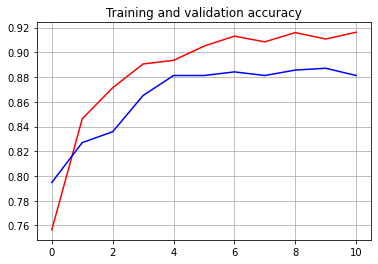

<Figure size 432x288 with 0 Axes>

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()


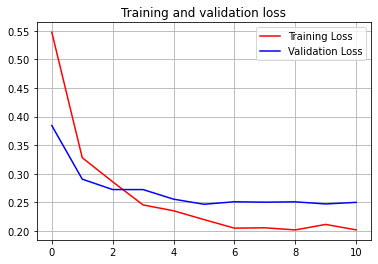

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

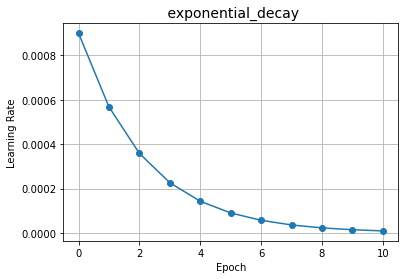

In [36]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(" exponential_decay", fontsize=14)
plt.grid(True)
plt.show()

(0.0, 1.0)

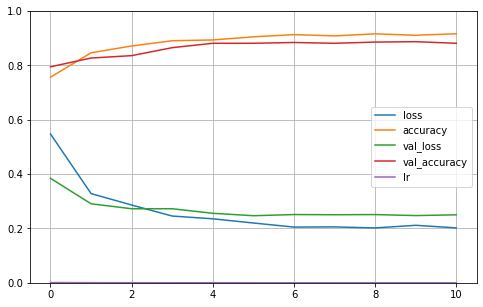

In [37]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [38]:
model.evaluate(test_generator, batch_size=1)

869/869 [==============================] - 63s 73ms/step - loss: 0.3747 - accuracy: 0.8032


[0.3746737539768219, 0.803222119808197]

In [39]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.91      0.70       216
           1       0.96      0.77      0.85       653

    accuracy                           0.80       869
   macro avg       0.76      0.84      0.78       869
weighted avg       0.86      0.80      0.82       869



In [ ]:
# cf_matrix = confusion_matrix(test_generator.classes, y_pred)
# Labels = ['looks good', 'sit up straight']
# plt.figure(figsize=(20, 8))
# heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.title('Confusion Matrix')
# plt.show()

## Save NN Model

In [40]:
model.save("/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey/vgg_model_test")

2023-04-17 03:16:59.486173: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/vgg_model_test/assets


## Webcam Testing

In [42]:
model = \
    keras.models.load_model(
    '/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey/vgg_model')
    

In [43]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74       216
           1       0.97      0.81      0.88       653

    accuracy                           0.84       869
   macro avg       0.79      0.86      0.81       869
weighted avg       0.88      0.84      0.85       869



**Test1**

In [6]:
test_image = \
    '/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey/bad1.jpg'

img_width, img_height = 150, 150
img = image.load_img(test_image, target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [16]:
test_image = \
    '/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/bad1.jpg'

img_width, img_height = 150, 150
img = image.load_img(test_image, target_size = (img_width, img_height))
img = np.array(img)
img = np.expand_dims(img, axis = 0)

In [21]:
img[0][0]

array([[111,  91,  80],
       [113,  93,  82],
       [115,  95,  84],
       [117,  97,  86],
       [119,  99,  90],
       [119,  99,  90],
       [120, 100,  91],
       [121, 101,  90],
       [122, 102,  91],
       [126, 102,  92],
       [127, 103,  93],
       [128, 104,  94],
       [128, 104,  94],
       [127, 105,  94],
       [130, 108,  97],
       [130, 108,  97],
       [128, 108,  97],
       [130, 110,  99],
       [131, 111, 102],
       [133, 113, 104],
       [134, 114, 103],
       [134, 114, 103],
       [132, 114, 100],
       [132, 114, 100],
       [133, 113, 102],
       [133, 113, 102],
       [132, 112, 101],
       [133, 113, 102],
       [132, 112, 101],
       [131, 111, 100],
       [130, 110,  99],
       [130, 110,  99],
       [128, 108,  97],
       [128, 108,  97],
       [126, 106,  95],
       [126, 106,  95],
       [125, 105,  94],
       [123, 103,  92],
       [124, 104,  93],
       [122, 102,  91],
       [122, 102,  91],
       [122, 102

In [6]:
# tttest = np.array([[[1.0054101e-12, 1.0000000e+00]]])
# tttest[0][0][1]

In [17]:
model.predict(img)

array([[1.0054101e-12, 1.0000000e+00]], dtype=float32)

In [18]:
labels = ['looks good', 'sit up straight']
print(labels[1])
model.predict(img)[0][1] 

sit up straight


1.0

In [19]:
labels = ['looks good', 'sit up straight']
print(labels[0])
model.predict(img)[0][0]

looks good


1.0054101e-12

In [12]:
if model.predict(img)[0][1] > model.predict(img)[0][0]:
    print("Testing - True")

Testing - True


In [81]:
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
good_frames = 0
bad_frames = 0 
chime.theme("mario")

# Initiate holistic model

while cap.isOpened():
    ret, frame = cap.read()

    # Recolor Feed
    images = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    images.flags.writeable = False        

    # Recolor image back to BGR for rendering
    images.flags.writeable = True   
    images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)

    # Export coordinates
    try:
        # Extract Pose landmarks
        
        img = cv2.resize(images, (150, 150))
        # img = Image.fromarray(img, 'RGB')
        img = np.array(img)
        img = np.expand_dims(img, axis = 0)
        # print(img) - working
        
        # Make Detections
        # X = np.array(pd.DataFrame([row]))
        pose_detection_value = model.predict(img)[0][0]
        comp_pose_detection_value = model.predict(img)[0][1]
        
        if pose_detection_value >= comp_pose_detection_value:
            pose_detection_class = 'Good'
            pose_detection_prob = pose_detection_value
        else:
            pose_detection_class = 'Sit Up Straight'
            pose_detection_prob = comp_pose_detection_value

        if pose_detection_class == 'Good':
            good_frames += 1
            bad_frames = 0
        else:
            good_frames = 0
            bad_frames += 1


        good_time = (1. / fps) * good_frames
        bad_time = (1. / fps) * bad_frames


        # To display the text, grab ear coords
        coords = tuple(250,100)

        if pose_detection_class == 'Good':
            cv2.rectangle(images, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
                          (0, 128, 0), -1)
        else:
            cv2.rectangle(images, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(pose_detection_class)*16, coords[1]-30), 
                          (105,105,105), -1)


        cv2.putText(images, pose_detection_class, coords, 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Get status box
        if pose_detection_class == 'Good':
            cv2.rectangle(images, (0,0), (250, 60), (0, 128, 0), -1)
        else:
            cv2.rectangle(images, (0,0), (250, 60), (105,105,105), -1)

        # Display Class
        cv2.putText(images, 'CLASS'
                    , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(images, pose_detection_class.split(' ')[0]
                    , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display Probability
        cv2.putText(images, 'PROB'
                    , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(images, str(round(pose_detection_prob,2))
                    , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    except:
        pass

    # if bad_time > 60:
    #         chime.warning()
    #         bad_frames = 0

    cv2.imshow('Raw Webcam Feed', images)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

## TFLite: Reduce the model size

https://www.dlology.com/blog/how-to-compress-your-keras-model-x5-smaller-with-tensorflow-model-optimization/

In [3]:
# Create the .tflite file
converter = \
    tf.lite.TFLiteConverter.from_saved_model(
    "/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/vgg_model"
    )

tflite_model_file =\
    "/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/vgg_model/vgg_model.tflite"

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16] # quantize to FP16
tflite_model = converter.convert()

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

2023-04-14 09:39:59.725202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 09:40:00.546797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-14 09:40:00.546819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-14 09:40:00.547595: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/vgg_model
2023-04-14 09:40:00.553277: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-14 09:40:00.553295: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if prese

In [4]:
interpreter = tf.lite.Interpreter(model_path = tflite_model_file)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [5]:
test_image = \
    '/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/bad1.jpg'

img_width, img_height = 150, 150
img = image.load_img(test_image, target_size = (img_width, img_height))
img = image.img_to_array(img)
input_test = np.expand_dims(img, axis = 0)
output_test = 1.

In [7]:
input_test.dtype

dtype('float32')

In [8]:
input_test_numpy = np.array(input_test, dtype=np.float32)

In [9]:
input_test_numpy.dtype

dtype('float32')

In [10]:
len(input_test)

1

In [11]:
# resizing
interpreter.resize_tensor_input(input_details[0]['index'], (len(input_test), 150, 150,3))
interpreter.resize_tensor_input(output_details[0]['index'], (len(input_test),2))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [12]:
interpreter.set_tensor(input_details[0]['index'], input_test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
print(tflite_model_predictions)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (1, 2)
[[1.0249878e-12 1.0000000e+00]]


In [13]:
tflite_model_predictions[0][0]

1.0249878e-12

In [6]:
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
good_frames = 0
bad_frames = 0 
chime.theme("mario")

# Initiate holistic model

while cap.isOpened():
    ret, frame = cap.read()

    # Recolor Feed
    images = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    images.flags.writeable = False        

    # Recolor image back to BGR for rendering
    images.flags.writeable = True   
    images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)


        
    img = cv2.resize(images, (150, 150))
    # img = Image.fromarray(img, 'RGB')
    img = np.array(img)
    img = np.expand_dims(img, axis = 0)
    img = np.array(img, dtype=np.float32)
    # print(img) - working

    interpreter.resize_tensor_input(input_details[0]['index'], (len(img), 150, 150,3))
    interpreter.resize_tensor_input(output_details[0]['index'], (len(img),2))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

    # Make Detections
    # X = np.array(pd.DataFrame([row]))
    pose_detection_value = tflite_model_predictions[0][0]
    comp_pose_detection_value = tflite_model_predictions[0][1]
    # print(pose_detection_value)

    if pose_detection_value >= comp_pose_detection_value:
        pose_detection_class = 'Good'
        pose_detection_prob = pose_detection_value
    else:
        pose_detection_class = 'Sit Up Straight'
        pose_detection_prob = comp_pose_detection_value

    # print(pose_detection_class)
    # print(pose_detection_prob)

    if pose_detection_class == 'Good':
        good_frames += 1
        bad_frames = 0
    else:
        good_frames = 0
        bad_frames += 1

    good_time = (1. / fps) * good_frames
    bad_time = (1. / fps) * bad_frames


    # To display the text, grab ear coords
    coords = (250, 100)   # (288, 127) Good / (348, 105) Bad


    if pose_detection_class == 'Good':
        cv2.rectangle(images, 
                      (coords[0], coords[1]+5), 
                      (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
                      (0, 128, 0), -1)
    else:
        cv2.rectangle(images, 
                      (coords[0], coords[1]+5), 
                      (coords[0]+len(pose_detection_class)*16, coords[1]-30), 
                      (105,105,105), -1)


    cv2.putText(images, pose_detection_class, coords, 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Get status box
    if pose_detection_class == 'Good':
        cv2.rectangle(images, (0,0), (250, 60), (0, 128, 0), -1)
    else:
        cv2.rectangle(images, (0,0), (250, 60), (105,105,105), -1)

    # Display Class
    cv2.putText(images, 'CLASS'
                , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(images, pose_detection_class.split(' ')[0]
                , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Display Probability
    cv2.putText(images, 'PROB'
                , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(images, str(round(pose_detection_prob,2))
                , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    
    if bad_time > 60:
            chime.warning()
            bad_frames = 0

    cv2.imshow('Raw Webcam Feed', images)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8582335
4.3254996e-29
5.4969135e-35
0.0
4.4e-43
7.469117e-22
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.00029282767
2.784405e-08
6.938647e-38
6.2307e-41
6e-45
2.86825e-25
1e-45
5.3975e-41
6.65315e-40
6.358162e-37
1.6898962e-35
0.0
1.501e-42
2.10708e-40
4.8045422e-36
2.0328992e-34
3.69377e-39
0.0
0.0
1e-45
8e-45
1.8e-43
0.0
0.0
0.0
0.0
0.0
5.2709286e-34
5.7210264e-30
4e-44
0.0
0.0
0.0
2.336329e-27
5.7851913e-32
1.4526289e-30
1.929867e-31
2.8195079e-33
0.0
0.0
1e-45
0.0
0.0
2.3193192e-31
9.137342e-27
2.2970474e-27
4.850342e-28
1.1691809e-30
9.453858e-28
9.0105885e-34
4.747552e-29
1.9874548e-31
3.5812743e-30
3.269818e-15
3.7545963e-19
3.7418658e-29
9.093889e-39
3.6e-43
4.8154e-40
6.5561604e-38
0.0
5.3536776e-38
6.0816513e-35
7.3769625e-33
3.7178212e-36
2.6e-43
6.987772e-20
1.0
1.0
0.99993384
0.99034905
3.3090107e-08
5.7723496e-06
0.001200993
2.751191e-05
7.772339e-06
0.0019797808
0.8281331

KeyboardInterrupt: 

## Requirements.txt

In [1]:
!pip install pipreqs

In [2]:
!pipreqs /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe

INFO: Successfully saved requirements file in /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe/requirements.txt
